# ChoiEtAl2022-JDQS-RiskParity

### Title: 
__Improved iterative methods for solving risk parity portfolio__

### Authors:
* Jaehyuk Choi ([@jaehyukchoi](https://github.com/jaehyukchoi))
* Chen Rong

### Abstract:
Risk parity, also known as equal risk contribution, has recently gained increasing attention as a portfolio allocation method. However, solving portfolio weights must resort to numerical methods as the analytic solution is not available. This study improves two existing iterative methods: the cyclical coordinate descent (CCD) and Newton methods. The authors enhance the CCD method by simplifying the formulation using a correlation matrix and imposing an additional rescaling step. The authors also suggest an improved initial guess inspired by the CCD method for the Newton method. Numerical experiments show that the improved CCD method performs the best and is approximately three times faster than the original CCD method, saving more than 40% of the iterations.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import scipy as sp
import time 

### Uncomment below if you want to run on your modified code
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf

np.set_printoptions(precision=3)

## An example in Bai et al. (2016)
Bai, X., Scheinberg, K., & Tutuncu, R. (2016). Least-squares approach to risk parity in portfolio selection. Quantitative Finance, 16(3), 357–376. https://doi.org/10.1080/14697688.2015.1031815

In [3]:
### Section 6.1
cov = np.array([
    [ 94.868, 33.750, 12.325, -1.178, 8.778 ],
    [ 33.750, 445.642, 98.955, -7.901, 84.954 ],
    [ 12.325, 98.955, 117.265, 0.503, 45.184 ],
    [ -1.178, -7.901, 0.503, 5.460, 1.057 ],
    [ 8.778, 84.954, 45.184, 1.057, 34.126 ]
])/10000

In [4]:
m = pf.RiskParity(cov=cov)
### Improved CCD method
### Tables 2, 3, and 4 risk parity portfolio (1)
print(f'Risk parity portfolio (1): {m.weight()}' )
print(m._result)

Risk parity portfolio (1): [0.125 0.047 0.083 0.613 0.132]
{'err': 2.2697290741335863e-07, 'n_iter': 6}


In [5]:
### Original CCD method by Griveau-Billion et al. (2013)
### Tables 2, 3, and 4 risk parity portfolio (1)
print(m.weight_ccd_original())
print(m._result)

[0.125 0.047 0.083 0.613 0.132]
{'err': 7.886915636690084e-07, 'n_iter': 11}


In [6]:
### Table4 risk parity portfolio (2)
m = pf.RiskParity(cov=cov, longshort=[-1, 1, 1, 1, 1])
print(f'Risk parity portfolio (2): {m.weight()}' )
### Table4 risk parity portfolio (3)
m = pf.RiskParity(cov=cov, longshort=[1, -1, 1, 1, 1])
print(f'Risk parity portfolio (3): {m.weight()}' )
### Table4 risk parity portfolio (4)
m = pf.RiskParity(cov=cov, longshort=[1, 1, -1, 1, 1])
print(f'Risk parity portfolio (4): {m.weight()}' )

Risk parity portfolio (2): [-0.223  0.074  0.125  0.82   0.204]
Risk parity portfolio (3): [ 0.157 -0.128  0.124  0.538  0.309]
Risk parity portfolio (4): [ 0.154  0.073 -0.285  0.717  0.341]


# Choi et al. (2022) Test 1

## Test 1: all eigenvalues sampled from independent uniform random variables between 0 and 1.
## Test 2: 80% of eigenvalues sampled from independent uniform random variables between 0 and 1, and 20% set to zero.

In [7]:
### choose 1 or 2
test_no = 1  # or 2

## Generating correlation matrices and saving them to local folder
We do this to measure time for solving weights only 

In [8]:
rep = 20  # repeat: the paper used 200

n_grid = np.array([
    25, 50, 75, 100, 125, 150, 175, 
    200, 250, 300, 400, 500, 600
])

np.random.seed(123456)
for n in n_grid:
    mat = np.zeros((rep, int(n*(n-1)/2)), dtype=np.float32)
    print(n, end=', ')

    for i in range(rep):
        if test_no == 1:
            m = pf.RiskParity.init_random(n)
        elif test_no == 2:
            m = pf.RiskParity.init_random(n, zero_ev=int(n/5))
        else:
             raise ValueError(f"Invalid test_no")

        cor = m.cor_m
        ind = np.tril_indices(n,-1)
        mat[i,:] = cor[ind]

    np.savez(f'Test{test_no}-Cor-n{n:03d}', mat=mat, n=n)

25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 

In [9]:
tol = 1e-6
t_grid = np.zeros(shape=(n_grid.shape[0], 3))
k_grid = np.zeros(shape=(n_grid.shape[0], 3))
nz_newton = 0

In [10]:
for i, n in enumerate(n_grid):
    budget = np.full(n, 1/n)

    file = np.load(f'Test{test_no}-Cor-n{n:03d}.npz')
    mat = file['mat']
    rep = mat.shape[0] 

    ind = np.tril_indices(n,-1)
    print(n, end=', ')
    
    for j in range(rep):
        
        cov = np.zeros((n, n))
        cov[ind] = mat[j,:]
        cov += cov.T
        np.fill_diagonal(cov, 1.0)

        m = pf.RiskParity(cov=cov, budget=budget)
        
        ### Improved Newton Method
        start_time = time.time()
        ww = m.weight_newton(tol)
        
        t_grid[i, 0] += time.time() - start_time
        k_grid[i, 0] += m._result['n_iter']
        assert np.all( np.abs(ww*(cov@ww)/(ww@cov@ww) - budget) < 10*tol )
        # count if ww has negative weights
        if not np.all(ww>0):
            nz_newton += 1
        
        ### Original CCD Method
        start_time = time.time()
        ww = m.weight_ccd_original(tol)        
        t_grid[i, 1] += time.time() - start_time
        k_grid[i, 1] += m._result['n_iter']
        if ww is not None:
            assert np.all( np.abs(ww*(cov@ww)/(ww@cov@ww) - budget) < tol )

        ### Improved CCD Method
        start_time = time.time()
        ww = m.weight(tol)
        t_grid[i, 2] += time.time() - start_time
        k_grid[i, 2] += m._result['n_iter']
        assert np.all( np.abs(ww*(cov@ww)/(ww@cov@ww) - budget) < tol )

t_grid /= rep/1000  # msec unit
k_grid /= rep

25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 

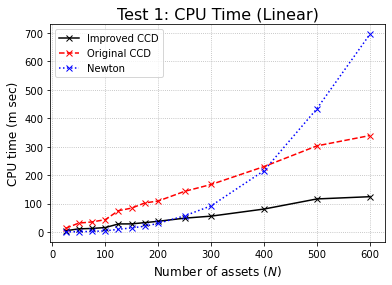

In [11]:
plt.plot(n_grid, t_grid[:,2], color='black', linestyle='-', marker='x', label='Improved CCD')
plt.plot(n_grid, t_grid[:,1], color='red', linestyle='--', marker='x', label='Original CCD')
plt.plot(n_grid, t_grid[:,0], color='blue', linestyle=':', marker='x', label='Newton')
plt.grid(linestyle=':')
plt.title(f'Test {test_no}: CPU Time (Linear)', fontsize=16)
plt.xlabel('Number of assets ($N$)', fontsize=12)
plt.ylabel('CPU time (m sec)', fontsize=12)
plt.legend()
#plt.savefig('../Latex/images/Time.pdf', bbox_inches='tight')
#plt.savefig('../Latex/images/Time.png', bbox_inches='tight')
plt.show()

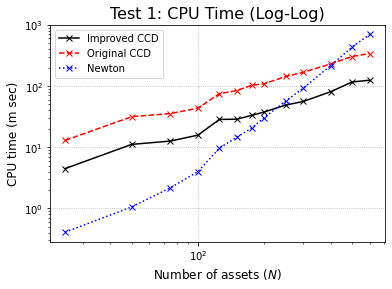

In [12]:
plt.loglog(n_grid, t_grid[:,2], color='black', linestyle='-', marker='x', label='Improved CCD')
plt.loglog(n_grid, t_grid[:,1], color='red', linestyle='--', marker='x', label='Original CCD')
plt.loglog(n_grid, t_grid[:,0], color='blue', linestyle=':', marker='x', label='Newton')
plt.grid(linestyle=':')
plt.title(f'Test {test_no}: CPU Time (Log-Log)', fontsize=16)
plt.xlabel('Number of assets ($N$)', fontsize=12)
plt.ylabel('CPU time (m sec)', fontsize=12)
plt.legend()
#plt.savefig('../Latex/images/TimeLogLog.pdf', bbox_inches='tight')
#plt.savefig('../Latex/images/TimeLogLog.png', bbox_inches='tight')
plt.show()

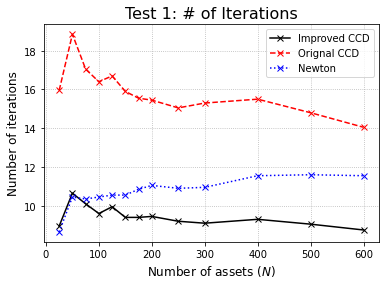

In [13]:
plt.plot(n_grid, k_grid[:,2], color='black', linestyle='-', marker='x', label='Improved CCD')
plt.plot(n_grid, k_grid[:,1], color='red', linestyle='--', marker='x', label='Orignal CCD')
plt.plot(n_grid, k_grid[:,0], color='blue', linestyle=':', marker='x', label='Newton')
#plt.ylim([5,20])
plt.grid(linestyle=':')
plt.title(f'Test {test_no}: # of Iterations', fontsize=16)
plt.xlabel('Number of assets ($N$)', fontsize=12)
plt.ylabel('Number of iterations', fontsize=12)
plt.legend()
#plt.savefig('../Latex/images/Iter.pdf', bbox_inches='tight')
#plt.savefig('../Latex/images/Iter.png', bbox_inches='tight')
plt.show()